# Real network

Corresponding to Cahpter 3.5, 3.7 in the book [Network Science Book](https://www.networksciencebook.com/) by Albert-László Barabási



In [1]:
!pip install numpy matplotlib networkx pandas 

Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user


## Load datasets


In [1]:
graph_list=[]
name_list=[]

### C. elegans Connectome Dataset

Number of nodes: 260
Number of edges: 950


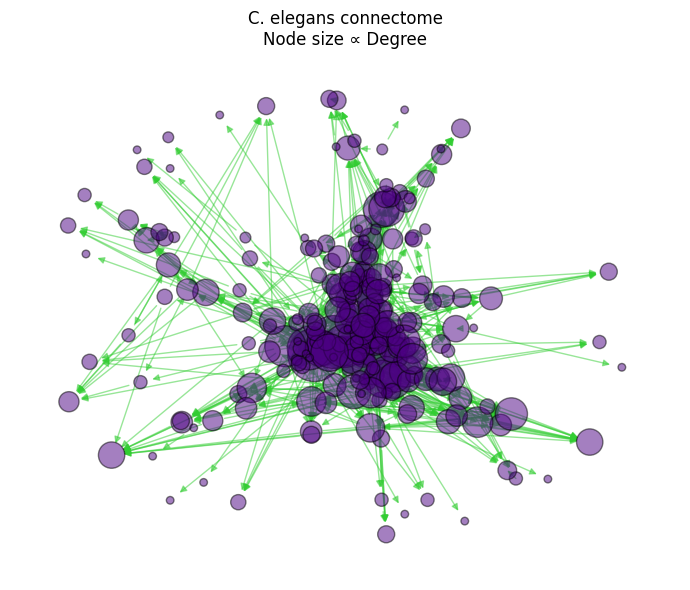

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# downloaded from https://www.wormwiring.org/
df = pd.read_excel('./Data/celegans_connectome.xlsx')
chemical_synapses = df[df['Type'] == 'S']

# Inspect the DataFrame to identify the correct columns
# print(df.columns)

G_celegans = nx.from_pandas_edgelist(chemical_synapses, source='Neuron 1', target='Neuron 2', create_using=nx.DiGraph())
graph_list.append(G_celegans)
name_list.append("C. elegans connectome")

print(f"Number of nodes: {G_celegans.number_of_nodes()}")
print(f"Number of edges: {G_celegans.number_of_edges()}")

def visualize_graph_with_degree_size(G, layout_func=nx.spring_layout, title="Graph Visualization"):
    """
    Visualize a graph where node size is proportional to its degree.
    
    Parameters:
        G (networkx.Graph): The input graph
        layout_func (function): Layout function like nx.spring_layout
        title (str): Title of the plot
    """
    degrees = dict(G.degree())
    node_sizes = [v * 30 for v in degrees.values()]  # scale factor

    pos = layout_func(G, seed=9)

    plt.figure(figsize=(7, 6))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='indigo', edgecolors='black',alpha=0.5)
    nx.draw_networkx_edges(G, pos, alpha=0.5,edge_color='limegreen')
    # nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"{title}\nNode size ∝ Degree")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_graph_with_degree_size(G_celegans, title="C. elegans connectome")

note: positions of nodes are still randomly generated, same below

### Scientific Collaboration Network (COLLAB Dataset)

In [3]:
import networkx as nx

# Condensed matter collaborations 2005 download from https://websites.umich.edu/~mejn/netdata/

# Let's convert the 209th graph in the dataset

G_collab = nx.read_gml("./Data/cond-mat-2005/cond-mat-2005.gml", label="id")

print(f"Number of nodes: {G_collab.number_of_nodes()}")
print(f"Number of edges: {G_collab.number_of_edges()}")
graph_list.append(G_collab)
name_list.append("Collaboration network")
# visualize_graph_with_degree_size(G_collab, title="Collaboration network")

Number of nodes: 40421
Number of edges: 175692


### Social network (Facebook)

Number of nodes: 4039
Number of edges: 88234


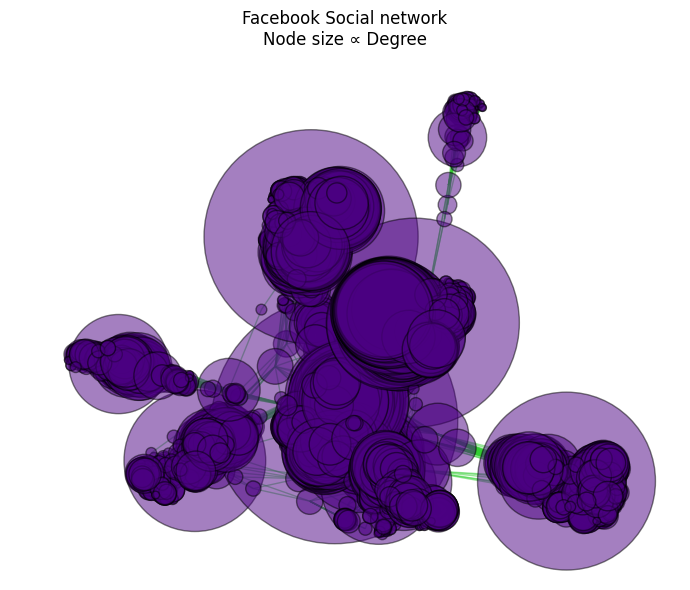

In [4]:
# Download from Stanford Large Network Dataset Collection https://snap.stanford.edu/data/ego-Facebook.html

import networkx as nx

# Load an edge list
G_social =  nx.read_edgelist("./Data/facebook_combined.txt", nodetype=int)


print(f"Number of nodes: {G_social.number_of_nodes()}")
print(f"Number of edges: {G_social.number_of_edges()}")

graph_list.append(G_social)
name_list.append("Facebook Social network")
visualize_graph_with_degree_size(G_social, title="Facebook Social network")

## degree distribution for real network

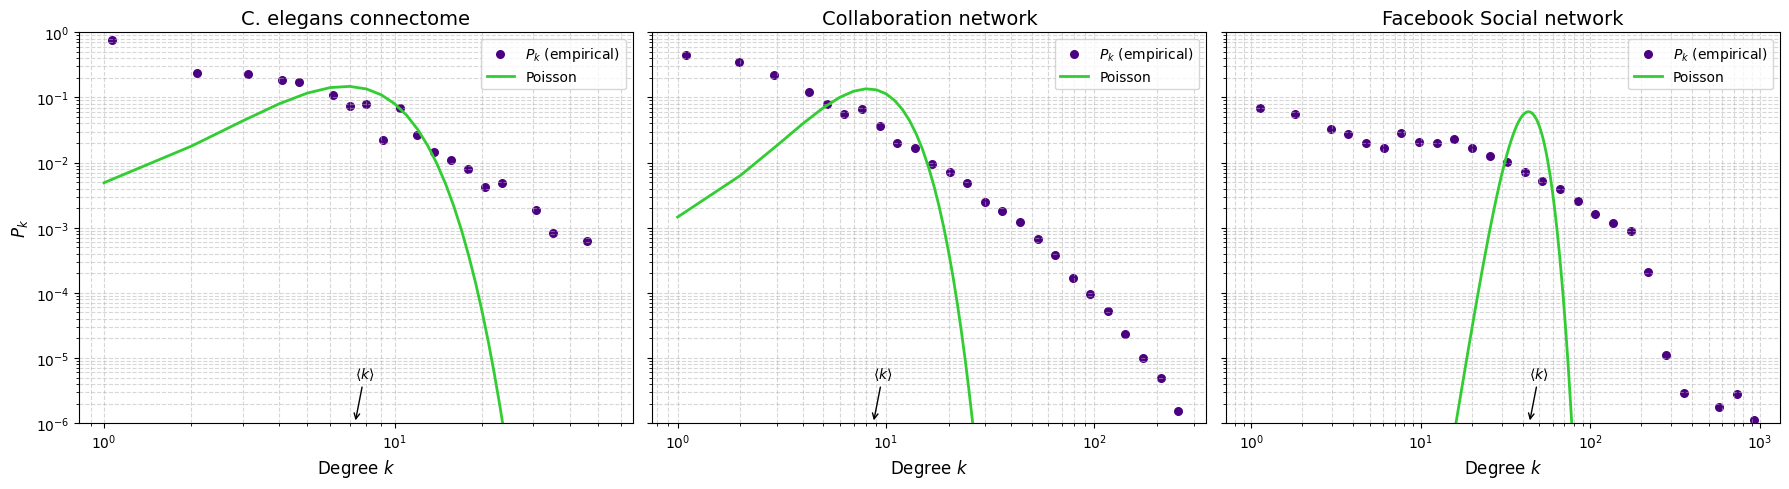

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.stats as stats

def log_binned_degree_distribution(degrees, bins=30):
    """
    Compute log-binned degree distribution: returns midpoints and probability density.
    """
    degrees = np.array(degrees)
    min_deg = max(degrees.min(), 1)  # avoid log(0)
    max_deg = degrees.max()
    log_bins = np.logspace(np.log10(min_deg), np.log10(max_deg), bins)

    hist, bin_edges = np.histogram(degrees, bins=log_bins, density=True)
    bin_centers = (bin_edges[:-1] * bin_edges[1:])**0.5  # geometric mean
    return bin_centers, hist

def plot_log_degree_distributions(graph_list, titles=None, bins=30):
    n_graphs = len(graph_list)
    fig, axes = plt.subplots(1, n_graphs, figsize=(6 * n_graphs, 5), sharey=True)

    if n_graphs == 1:
        axes = [axes]

    for i, (G, ax) in enumerate(zip(graph_list, axes)):
        degrees = [d for _, d in G.degree()]
        k_avg = np.mean(degrees)

        # Log-binned empirical degree distribution
        k_vals, pk_vals = log_binned_degree_distribution(degrees, bins=bins)

        # Poisson distribution (binned)
        k_range = np.arange(0, int(np.max(k_vals)) + 10)
        poisson_probs = stats.poisson.pmf(k_range, mu=k_avg)
        poisson_k = k_range[k_range > 0]
        poisson_pk = poisson_probs[k_range > 0]

        # Plot
        ax.scatter(k_vals, pk_vals, color="indigo", s=30, label=r"$P_k$ (empirical)")
        ax.plot(poisson_k, poisson_pk, color="limegreen", lw=2, label="Poisson")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim([10**(-6),10**(0)])
        ax.set_xlabel("Degree $k$", fontsize=12)
        if i == 0:
            ax.set_ylabel(r"$P_k$", fontsize=12)

        title = titles[i] if titles else f"Graph {i+1}"
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", linestyle='--', alpha=0.5)
        ax.legend(fontsize=10)

        # Indicate <k>
        ax.annotate(r"$\langle k \rangle$", xy=(k_avg, 1e-6), xytext=(k_avg, 5e-6),
                    arrowprops=dict(arrowstyle='->'), fontsize=10)

    plt.tight_layout()
    plt.show()


plot_log_degree_distributions(graph_list,titles=name_list)

## Real networks are supercritical

In [6]:
for graph,name in zip(graph_list,name_list):
    if nx.is_directed(graph):
        print(f"Graph: {name}, Number of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}, logN: {np.log(graph.number_of_nodes())}, <k>: { graph.number_of_edges()/graph.number_of_nodes() }")
    else:
        print(f"Graph: {name}, Number of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}, logN: {np.log(graph.number_of_nodes())}, <k>: { graph.number_of_edges()/graph.number_of_nodes()*2 }")
   


Graph: C. elegans connectome, Number of nodes: 260, Number of edges: 950, logN: 5.560681631015528, <k>: 3.6538461538461537
Graph: Collaboration network, Number of nodes: 40421, Number of edges: 175692, logN: 10.607104730879188, <k>: 8.693105069147226
Graph: Facebook Social network, Number of nodes: 4039, Number of edges: 88234, logN: 8.303752415563412, <k>: 43.69101262688784
